In [1]:
import copy
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from scipy import stats
from scipy.stats import kurtosis
from scipy.stats import norm
from scipy.stats import ttest_ind, ttest_rel

In [2]:
data = pd.read_csv("insight-test.csv")

# Data Processing
## Overview of Data
We also want to ensure that NaN doesn't exist, they contain the same data counts and there is no missing data

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 229847 entries, 0 to 229846
Data columns (total 32 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   user_id                 229847 non-null  int64  
 1   is_new                  229847 non-null  int64  
 2   time                    229847 non-null  object 
 3   voucher_type            38958 non-null   float64
 4   voucher_valid           41981 non-null   float64
 5   basket_amount           229847 non-null  float64
 6   voucher_max_amount      229847 non-null  float64
 7   voucher_percentage      229847 non-null  float64
 8   voucher_min_purchase    229847 non-null  float64
 9   voucher_amount          229847 non-null  float64
 10  trx_is_voucher          229847 non-null  int64  
 11  is_paid                 229847 non-null  int64  
 12  is_remitted             229847 non-null  int64  
 13  user_purchased_prior    229847 non-null  int64  
 14  num_voucher_errors  

## Handle Missing Vouchers
Since users without a valid vouchers are marked as 0, we will assume empty vouchers users doesn't hold any vouchers

In [4]:
data["voucher_type"].value_counts()

1.0    31969
0.0     6989
Name: voucher_type, dtype: int64

In [5]:
data["voucher_valid"].value_counts()

1.0    38958
0.0     3023
Name: voucher_valid, dtype: int64

In [6]:
data["voucher_type"] = data["voucher_type"].fillna(0)
data["voucher_valid"] = data["voucher_valid"].fillna(0)

### Handle Marketing Tier
We want to replace the `Tier_n to n`

We notice that the data is missing, since it is dangerous to assume anything. We will just remove it for now

In [7]:
data["marketing_tier"].value_counts()

tier_1    153695
tier_2     64509
tier_3     10688
tier_4       179
Name: marketing_tier, dtype: int64

In [8]:
data["marketing_tier"] = data["marketing_tier"].replace({
                                                    'tier_1': 1,
                                                    'tier_2': 2,
                                                    'tier_3': 3,
                                                    'tier_4': 4
                                                })

Remove the rows containing NaN values

In [9]:
data = data[data['marketing_tier'].notna()]

## Handle Time Data
We want to convert the string into readable datetime

In [10]:
data["time"] = pd.to_datetime(data["time"])
data["account_created_at"] = pd.to_datetime(data["account_created_at"])

As some visualisation are hard with timeseries, we will convert them into:

`time` : `time_month`, `time_day` # The transaction are all in 2015

`account_created_at` : `account_age` # In Days

In [11]:
data["time_month"] = data["time"].dt.month
data["time_day"] = data["time"].dt.day

data["account_age"] = (data["time"] - data["account_created_at"]).dt.days

## Drop Unused Columns


In [12]:
data = data.drop(columns=['time', 'account_created_at', 'user_id'])

# Data Visualisation
## Pearson Correlation of Features
The result ranges in -1 to 1: 1 shows a perfect correlation, 0 shows no correlation, -1 shows an opposite perfect correlation

In [13]:
corr_data = data.corr()

<AxesSubplot:>

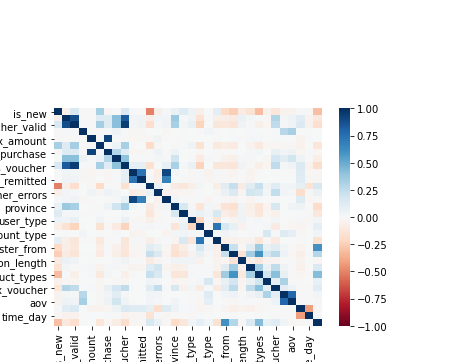

In [14]:
sns.heatmap(corr_data, cmap=plt.cm.RdBu, vmin=-1, vmax=1)

In [15]:
corr_data.style.background_gradient(cmap=plt.cm.RdBu, vmin=-1, vmax=1).set_precision(2)

In [16]:
# sns.pairplot(data.sample(n = 100))

# Data Exploration
## `is_new`
A potential success for any e-commerce platform is the large and growing number of user

In [17]:
corr_data['is_new'].sort_values()

user_purchased_prior     -0.503403
num_product_types        -0.309826
account_age              -0.301380
sessions                 -0.247502
user_register_from       -0.200251
num_visit_promo_page     -0.146333
num_trx_voucher          -0.122178
average_session_length   -0.080536
num_voucher_errors       -0.065058
user_group               -0.055309
voucher_type             -0.052824
num_trx                  -0.047010
aov                      -0.034818
gmv                      -0.031869
voucher_min_purchase     -0.012990
time_day                 -0.010209
voucher_max_amount       -0.007221
basket_amount            -0.007118
voucher_amount            0.001292
is_remitted               0.001705
account_type              0.005679
is_paid                   0.013374
time_month                0.015476
purchase                  0.021187
user_type                 0.059471
province                  0.067212
referrer_type             0.094068
marketing_tier            0.131109
trx_is_voucher      

Picking the top ones are:

- Voucher percentage (Likely to be voucher discounts)
- Voucher is valid
- Paid using the said voucher
- Marketing tier

The bottom ones are: (Opposite colleration, lower = new user)

(Good context) tells us which feature will bring new user
- Have the user purchased before
- User registered from

(Out of the context) we want to know which will attract new user, not which are the new user)
- Number of product types (Vague?)
- Account age
- Sessions

### Voucher Percentage

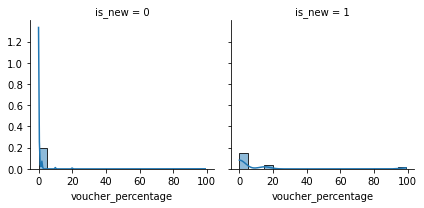

In [18]:
g = sns.FacetGrid(data, col='is_new')
g.map(sns.histplot, 'voucher_percentage', bins=20, kde=True, stat="density")

Poor visualisation, 0 is included, let's remove that

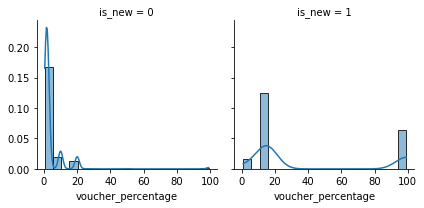

In [19]:
g = sns.FacetGrid(data.loc[data['voucher_percentage'] > 0], col='is_new')
g.map(sns.histplot, 'voucher_percentage', bins=20, kde=True, stat="density")

In [20]:
# data[data["is_new"] == 1]['voucher_percentage'].value_counts()

We can see that new user who come in using vouchers are more likely to use 10-15% discount vouchers, followed by 95-100% vouchers.

However, this argument can be countered as when a user purchase for the first time, they will get a vouchers.

### Voucher Valid

In [21]:
data[["voucher_valid", "is_new"]].groupby(['voucher_valid'], as_index=False).mean().sort_values(by='is_new', ascending=False)

voucher_valid    is_new
1            1.0  0.247337
0            0.0  0.105315

In [22]:
ttest_ind(data["voucher_valid"], data["is_new"])

Ttest_indResult(statistic=38.277314992301406, pvalue=0.0)

New User are more likely to have a valid voucher

### Using voucher in the transaction

In [23]:
data[["trx_is_voucher", "is_new"]].groupby(['trx_is_voucher'], as_index=False).mean().sort_values(by='is_new', ascending=False)

trx_is_voucher    is_new
1               1  0.249883
0               0  0.106823

In [24]:
ttest_ind(data["trx_is_voucher"], data["is_new"])

Ttest_indResult(statistic=27.519664386462328, pvalue=1.3973986400662235e-166)

New User are more likely to use a voucher for transaction

### Marketing Tier

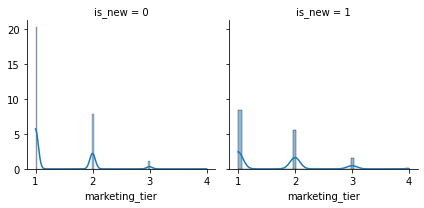

In [25]:
g = sns.FacetGrid(data, col='is_new')
g.map(sns.histplot, 'marketing_tier', kde=True, stat="density")

<AxesSubplot:xlabel='is_new', ylabel='marketing_tier'>

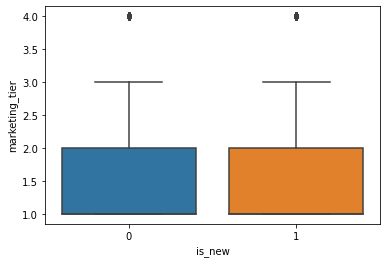

In [26]:
sns.boxplot(data = data, x = data["is_new"], y = data["marketing_tier"])

In [27]:
data[["is_new", "marketing_tier"]].groupby(['is_new'], as_index=False).mean().sort_values(by='marketing_tier', ascending=False)

is_new  marketing_tier
1       1        1.573486
0       0        1.348104

As both label follow similar distribution, thefore we cannot infer anythiong from it

### User purchased before

In [28]:
data[["user_purchased_prior", "is_new"]].groupby(['user_purchased_prior'], as_index=False).mean().sort_values(by='is_new', ascending=False)

user_purchased_prior    is_new
0                     0  0.350601
1                     1  0.000332

In [29]:
ttest_ind(data["user_purchased_prior"], data["is_new"])

Ttest_indResult(statistic=408.8777805881302, pvalue=0.0)

Initialy, we though that new user can buy multiple times in a short times. But the almost zero shows otherwise, making this feature useless

### User registred from

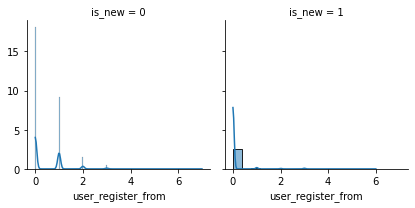

In [30]:
g = sns.FacetGrid(data, col='is_new')
g.map(sns.histplot, 'user_register_from', kde=True, stat="density")

In [31]:
# data[data["is_new"] == 1]['user_register_from'].value_counts()

For new user, they are mainly from 0. Whereas old user come from different platforms apart from 0

This means that platform 0 is currently attracting customers

## `is_paid`
A potential success for any e-commerce platform is the amount of success full transactions

In [32]:
corr_data['is_paid'].sort_values()

num_voucher_errors       -0.071239
num_visit_promo_page     -0.032808
account_type             -0.032356
sessions                 -0.026598
time_day                 -0.020590
voucher_max_amount       -0.018824
voucher_min_purchase     -0.017277
user_type                -0.013567
user_register_from       -0.013382
basket_amount            -0.012823
account_age              -0.011344
num_product_types        -0.004893
average_session_length   -0.004559
num_trx_voucher          -0.002499
voucher_percentage       -0.002424
voucher_amount           -0.002137
aov                      -0.000038
gmv                       0.001974
marketing_tier            0.003107
num_trx                   0.003733
is_new                    0.013374
user_purchased_prior      0.014285
user_group                0.015988
referrer_type             0.020584
voucher_valid             0.029249
province                  0.030300
voucher_type              0.032924
trx_is_voucher            0.086167
time_month          

It is a bit hard to infer anything from here. `purchase` and `is_remitted` are data connected to `is_paid`

However, certain times in the month affects the users paying

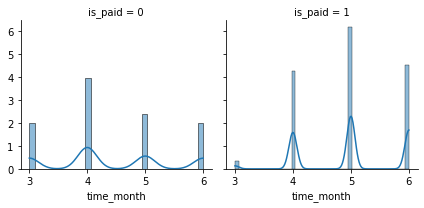

In [33]:
g = sns.FacetGrid(data, col='is_paid')
g.map(sns.histplot, 'time_month', kde=True, stat="density")

In May and June we have more users likely paying. In march, users are unlikely to pay

In [34]:
# data[data["is_paid"] == 1]["time_month"].value_counts(normalize=True)

In [35]:
# data[data["is_paid"] == 0]["time_month"].value_counts(normalize=True)

## `gmv` Gross Merchandise Value
Despite the number of customer. An income for any e-commerce platform is always measured by the value of the item ordered. A higher value will generate revenue due to the commision system

We Choose GMV over AOV (Average Order Value) due to the fact that GMV accounts for number of item in one transactions, where AOV averages that value.

In [36]:
corr_data['gmv'].sort_values()

is_new                   -0.031869
voucher_percentage       -0.010695
average_session_length   -0.004595
time_month               -0.003458
user_group               -0.003318
user_type                -0.002000
time_day                 -0.000362
marketing_tier            0.000021
voucher_max_amount        0.000950
referrer_type             0.001620
is_paid                   0.001974
is_remitted               0.005857
province                  0.005971
purchase                  0.006087
trx_is_voucher            0.016104
voucher_valid             0.017273
voucher_type              0.025879
num_voucher_errors        0.031864
voucher_min_purchase      0.031887
account_age               0.032303
user_purchased_prior      0.034864
user_register_from        0.035414
num_visit_promo_page      0.043653
sessions                  0.054864
num_product_types         0.075851
num_trx_voucher           0.102495
voucher_amount            0.112186
account_type              0.126875
basket_amount       

Picking the top ones are:

- Average Order Value
- Number of transactions
- basket amount
- account type
- voucher amount

### Averge Order Value

<AxesSubplot:xlabel='gmv', ylabel='aov'>

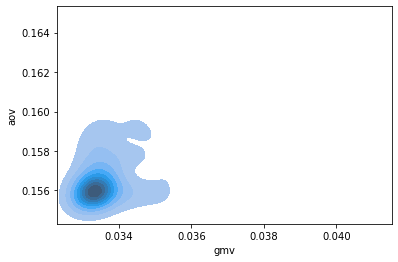

In [37]:
sns.kdeplot(data = data.sample(200), x = "gmv", y = "aov", fill=True)

There is very little relationship from the plots, we don't use scatter plot as they are too small

To further see the relationship, we will use a Q-Q plot

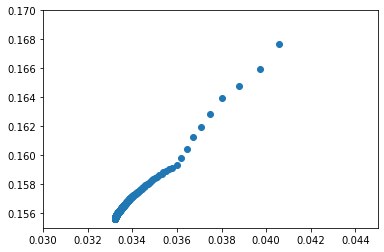

In [38]:
percs = np.linspace(0,100,501)
qn_a = np.percentile(data['gmv'], percs)
qn_b = np.percentile(data['aov'], percs)

plt.plot(qn_a,qn_b, ls="", marker="o", )

plt.xlim([0.03, 0.045])
plt.ylim([0.155, 0.17])
plt.show()

### Number of transaction

<AxesSubplot:xlabel='gmv', ylabel='num_trx'>

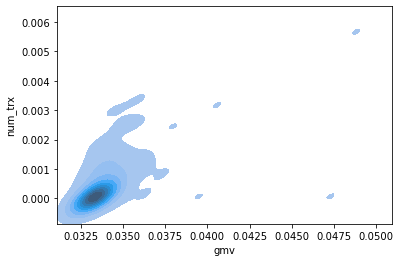

In [39]:
sns.kdeplot(data = data.sample(200), x = "gmv", y = "num_trx", fill=True)

Similarly, There some relationship from the plots

To further see the relationship, we will use a Q-Q plot

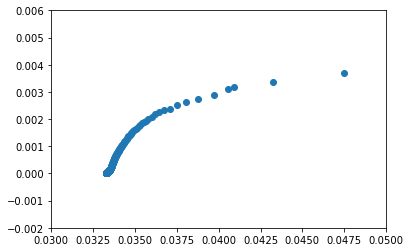

In [40]:
qn_a = np.percentile(data['gmv'], percs)
qn_b = np.percentile(data['num_trx'], percs)

plt.plot(qn_a,qn_b, ls="", marker="o", )

plt.xlim([0.03, 0.05])
plt.ylim([-0.002, 0.006])
plt.show()

### Basket Amount

<AxesSubplot:xlabel='gmv', ylabel='basket_amount'>

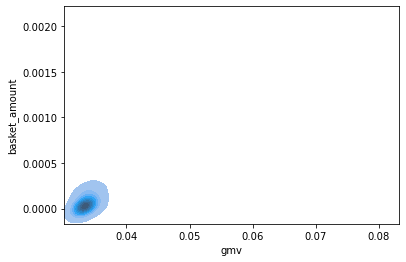

In [41]:
sns.kdeplot(data = data.sample(500), x = "gmv", y = "basket_amount", fill=True)

Similarly, There very little relationship from the plots

To further see the relationship, we will use a Q-Q plot

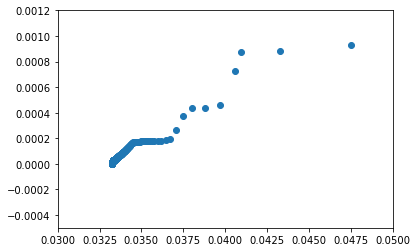

In [42]:
qn_a = np.percentile(data['gmv'], percs)
qn_b = np.percentile(data['basket_amount'], percs)

plt.plot(qn_a,qn_b, ls="", marker="o", )

plt.xlim([0.03, 0.05])
plt.ylim([-0.0005, 0.0012])
plt.show()

## basket_amount

In [43]:
corr_data['basket_amount'].sort_values()

purchase                 -0.013432
is_paid                  -0.012823
is_remitted              -0.008323
is_new                   -0.007118
user_group               -0.004679
time_day                 -0.003609
voucher_percentage       -0.003194
marketing_tier           -0.001710
sessions                 -0.001448
num_trx                  -0.000921
voucher_max_amount       -0.000244
referrer_type            -0.000024
user_type                 0.000216
num_product_types         0.001232
average_session_length    0.001375
user_register_from        0.001632
time_month                0.002015
account_age               0.002778
num_voucher_errors        0.003005
user_purchased_prior      0.003641
province                  0.006514
trx_is_voucher            0.008133
voucher_valid             0.009060
num_trx_voucher           0.009530
num_visit_promo_page      0.009941
voucher_type              0.012096
voucher_min_purchase      0.012802
account_type              0.038899
voucher_amount      

Very similar to gmv here,

Top ones are:

- aov
- gmv

Bottom ones are:
- purchase
- is_paid

### Average order Value

<AxesSubplot:xlabel='basket_amount', ylabel='aov'>

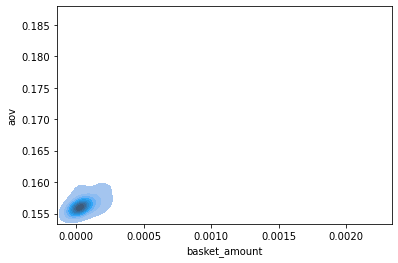

In [44]:
sns.kdeplot(data = data.sample(500), x = "basket_amount", y = "aov", fill=True)

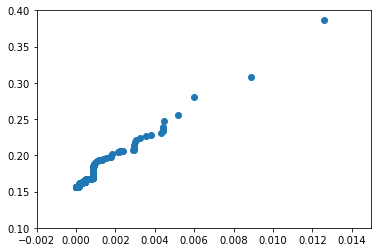

In [45]:
percs = np.linspace(0,100,10001)
qn_a = np.percentile(data['basket_amount'], percs)
qn_b = np.percentile(data['aov'], percs)

plt.plot(qn_a,qn_b, ls="", marker="o", )

plt.xlim([-0.002, 0.015])
plt.ylim([0.1, 0.4])
plt.show()

### Gross Merchandise Value

<AxesSubplot:xlabel='basket_amount', ylabel='gmv'>

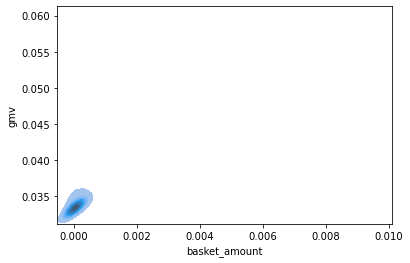

In [46]:
sns.kdeplot(data = data.sample(500), x = "basket_amount", y = "gmv", fill=True)

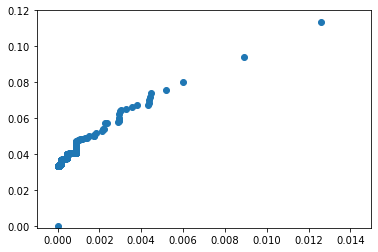

In [47]:
percs = np.linspace(0,100,10001)
qn_a = np.percentile(data['basket_amount'], percs)
qn_b = np.percentile(data['gmv'], percs)

plt.plot(qn_a,qn_b, ls="", marker="o", )

plt.xlim([-0.001, 0.015])
plt.ylim([-0.001, 0.12])
plt.show()

### purchase

More basket amount is unlikely to be purchased

In [48]:
data[["purchase", "basket_amount"]].groupby(['purchase'], as_index=False).mean().sort_values(by='basket_amount', ascending=False)

purchase  basket_amount
0         0       0.000309
1         1       0.000081

### is_paid

More basket amount is unlikey to be paid

In [49]:
data[["is_paid", "basket_amount"]].groupby(['is_paid'], as_index=False).mean().sort_values(by='basket_amount', ascending=False)

is_paid  basket_amount
0        0       0.000280
1        1       0.000081

## Data Distribution

In [50]:
for col in data.columns:
    print("{}'s kurtosis value: {}".format(col, kurtosis(data[col], fisher=True)))

is_new's kurtosis value: 2.8757894274462767
voucher_type's kurtosis value: 2.3468652259741996
voucher_valid's kurtosis value: 1.097622336313659
basket_amount's kurtosis value: 74902.37815859247
voucher_max_amount's kurtosis value: 2969.8238571638367
voucher_percentage's kurtosis value: 68.21589218642791
voucher_min_purchase's kurtosis value: 2184.101382341313
voucher_amount's kurtosis value: 260.5655419682439
trx_is_voucher's kurtosis value: 1.5201754014981024
is_paid's kurtosis value: 21.150731799383106
is_remitted's kurtosis value: 9.777743229669724
user_purchased_prior's kurtosis value: -1.7028776471311307
num_voucher_errors's kurtosis value: 579.3609002197038
purchase's kurtosis value: 26.241686280834422
province's kurtosis value: 3.827181567830145
marketing_tier's kurtosis value: 0.7567882130322339
user_type's kurtosis value: 9.636776488163605
user_group's kurtosis value: -1.6616860742210506
account_type's kurtosis value: 1344.640023369776
referrer_type's kurtosis value: 1.3412393

C:\Users\Joey\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


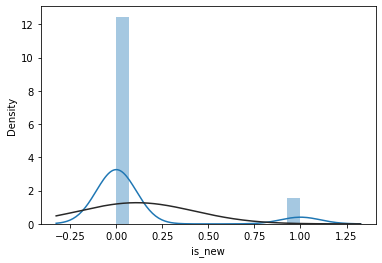

C:\Users\Joey\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


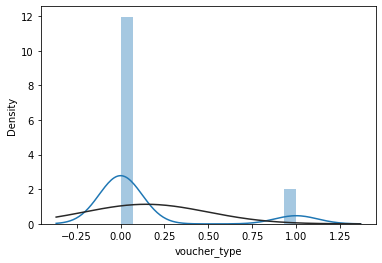

C:\Users\Joey\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


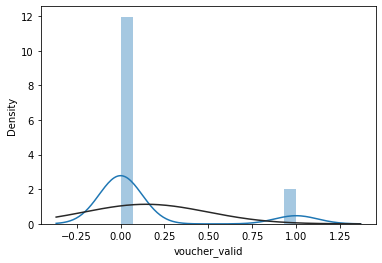

C:\Users\Joey\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


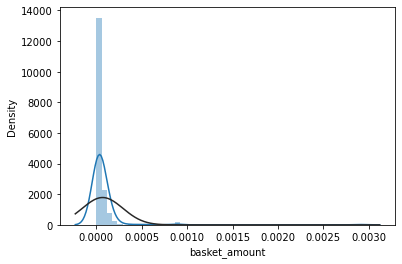

C:\Users\Joey\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Joey\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


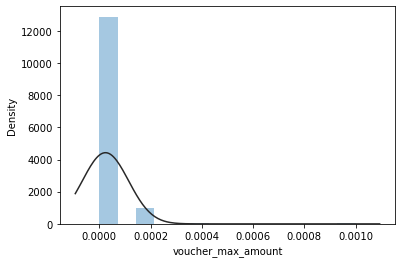

C:\Users\Joey\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


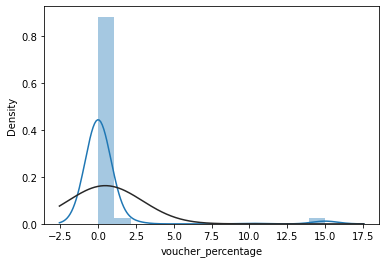

C:\Users\Joey\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


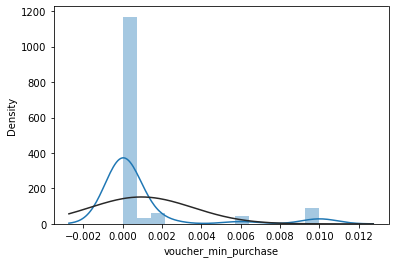

C:\Users\Joey\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


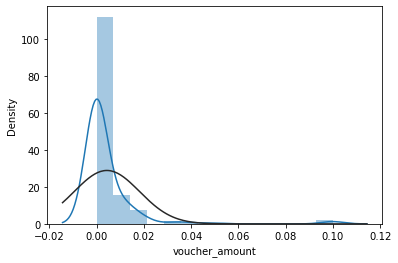

C:\Users\Joey\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


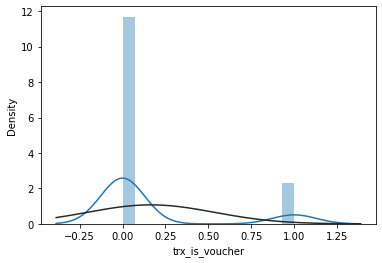

C:\Users\Joey\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


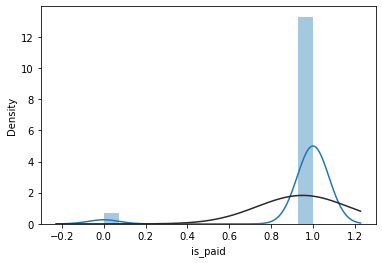

C:\Users\Joey\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


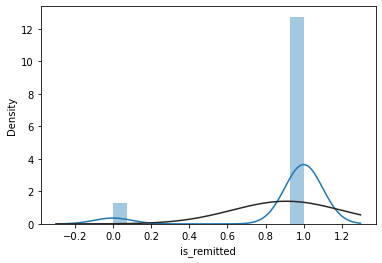

C:\Users\Joey\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


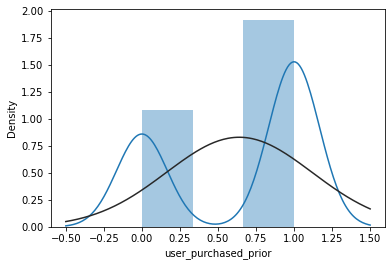

C:\Users\Joey\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


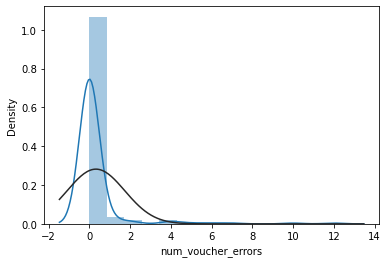

C:\Users\Joey\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


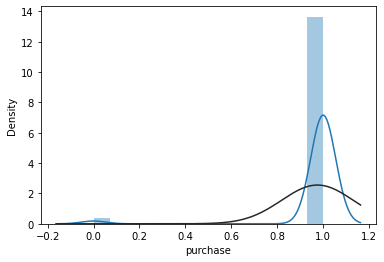

C:\Users\Joey\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


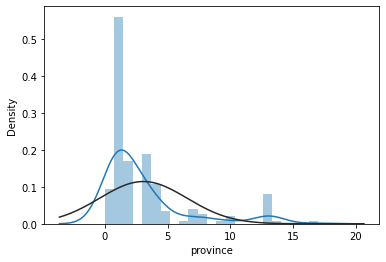

C:\Users\Joey\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


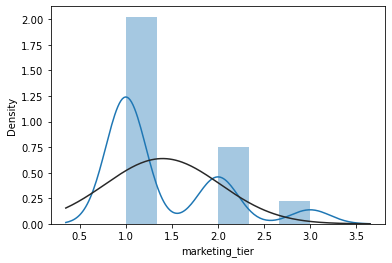

C:\Users\Joey\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


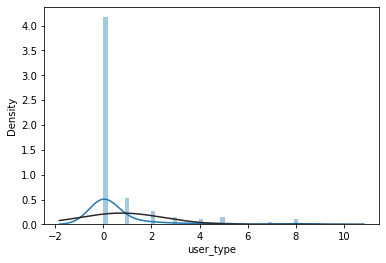

C:\Users\Joey\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


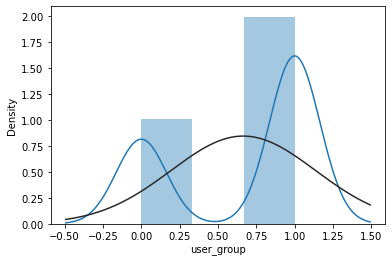

C:\Users\Joey\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


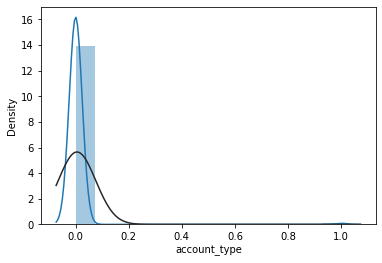

C:\Users\Joey\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


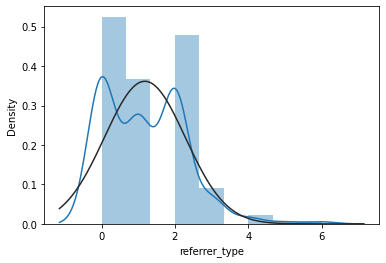

C:\Users\Joey\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


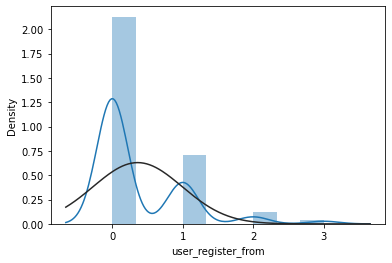

C:\Users\Joey\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


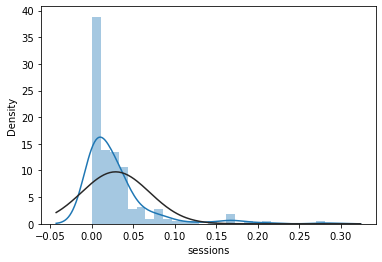

C:\Users\Joey\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


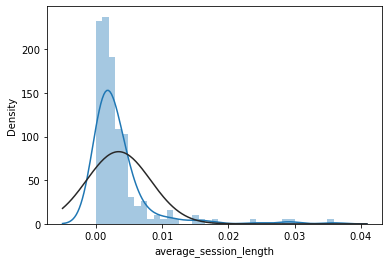

C:\Users\Joey\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


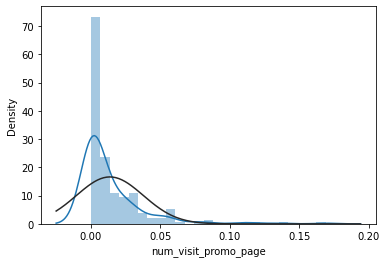

C:\Users\Joey\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


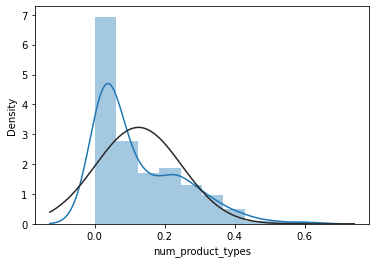

C:\Users\Joey\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


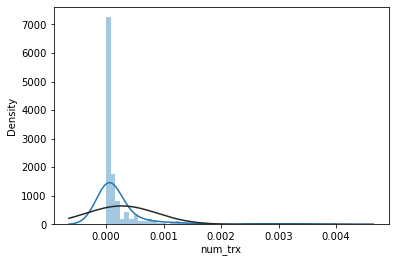

C:\Users\Joey\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


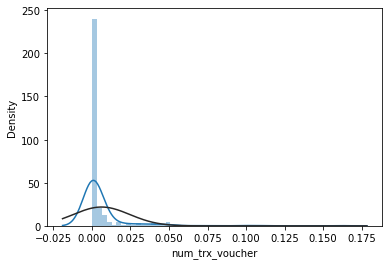

C:\Users\Joey\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


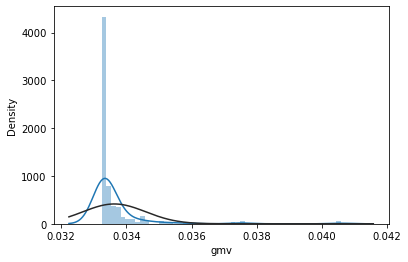

C:\Users\Joey\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


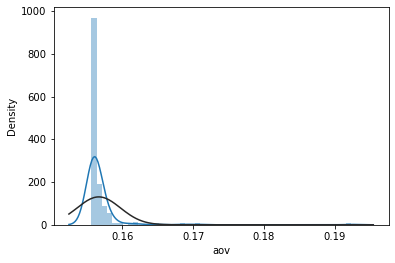

C:\Users\Joey\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


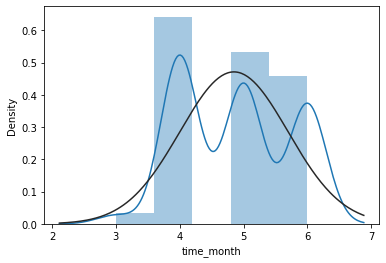

C:\Users\Joey\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


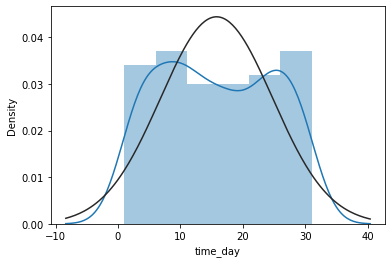

C:\Users\Joey\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


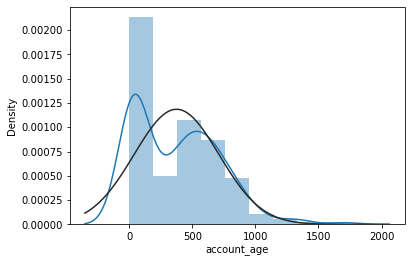

In [51]:
for col in data.columns:
    try:
        sns.distplot(data.sample(200)[col], fit=norm)
        plt.show()
    except:
        print("{} cannot be displayed".format(col))
    

Very poor distribution of data here, except for some. Binary data have a good kurt value, but poor histogram

We will remove extreme values, given that it only cut a small amount of our dataset

In [52]:
print("basket_amount", len(data[data["basket_amount"] >= 0.0005]))
print("voucher_max_amount", len(data[data["voucher_max_amount"] >= 0.0004]))
print("voucher_percentage", len(data[data["voucher_percentage"] >= 40]))
print("voucher_min_purchase", len(data[data["voucher_min_purchase"] >= 0.0004]))
print("voucher_amount", len(data[data["voucher_amount"] >= 0.06]))
print("num_voucher_erros", len(data[data["num_voucher_errors"] >= 7.5]))
print("average_session_length", len(data[data["average_session_length"] >= 7.5]))
print("num_visit_promo_page", len(data[data["num_visit_promo_page"] >= 0.1]))
print("num_trx", len(data[data["num_trx"] >= 0.002]))
print("num_trx_voucher", len(data[data["num_trx_voucher"] >= 0.1]))
print("gmv", len(data[data["gmv"] >= 0.04]))
print("aov", len(data[data["aov"] >= 0.16]))

basket_amount 2510
voucher_max_amount 2539
voucher_percentage 2765
voucher_min_purchase 40222
voucher_amount 3721
num_voucher_erros 4908
average_session_length 0
num_visit_promo_page 3866
num_trx 6898
num_trx_voucher 1065
gmv 2620
aov 5843


In [53]:
def removeData(data, col, condition):
    return data[data[col] < condition]

In [54]:
cols = ["basket_amount", "voucher_max_amount", "voucher_percentage", "voucher_amount", "num_voucher_errors", "average_session_length", "num_visit_promo_page", "num_trx", "num_trx_voucher", "gmv", "aov"]
conditions = [0.0005, 0.0004, 40, 0.06, 7.5, 7.5, 0.1, 0.002, 0.1, 0.04, 0.16]

test_data = copy.deepcopy(data)
for i in range(len(cols)):
    test_data = removeData(test_data, cols[i], conditions[i])
print(len(test_data))
print(len(test_data)/len(data))

204082
0.8909115514403831


In [55]:
# data = test_data

This lowers the accuracy of all model by 1-3%

Therefore, we will not remove any data

# ML Model

With all these data, why not create a model that predict future user if they might be a buyer in the future

It also doubles to check which feature is the most important

In [56]:
import eli5
import xgboost as xgb

from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler, NearMiss, EditedNearestNeighbours, InstanceHardnessThreshold, OneSidedSelection, NeighbourhoodCleaningRule, CondensedNearestNeighbour

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier

In [57]:
def createXY(train_data, test_data, col, drop_col=None):
    if drop_col == None:
        drop_col = [col]
    # Train Data
    X_train = train_data.drop(columns=drop_col)
    Y_train = train_data[col]
    # Shuffle Train Data
    X_train, Y_train = shuffle(X_train, Y_train, random_state=0)
    # Test Data
    X_test = test_data.drop(columns=drop_col)
    Y_test = test_data[col]
    return X_train, Y_train, X_test, Y_test

In [112]:
train_data, test_data = train_test_split(data, test_size=0.1)
# Create Dataset
isNew_X_train, isNew_Y_train, isNew_X_test, isNew_Y_test = createXY(train_data, test_data, 'is_new')
isPaid_X_train, isPaid_Y_train, isPaid_X_test, isPaid_Y_test = createXY(train_data, test_data, 'is_paid')
isPaid_Unconnected_X_train, isPaid_Unconnected_Y_train, isPaid_Unconnected_X_test, isPaid_Unconnected_Y_test = createXY(train_data, test_data, 'is_paid', drop_col=['is_paid', 'is_remitted', 'purchase'])
gmv_X_train, gmv_Y_train, gmv_X_test, gmv_Y_test = createXY(train_data, test_data, 'gmv')
basketAmount_X_train, basketAmount_Y_train, basketAmount_X_test, basketAmount_Y_test = createXY(train_data, test_data, 'basket_amount')

In [59]:
# train_data, test_data = train_test_split(data, test_size=0.1)
# # Train data for is_new, is_paid and gmv respectively
# isNew_X_train = train_data.drop(columns=['is_new'])
# isNew_Y_train = train_data['is_new']
# isPaid_X_train = train_data.drop(columns=['is_paid'])
# isPaid_Y_train = train_data['is_paid']
# isPaid_Unconnected_X_train = train_data.drop(columns=['is_paid', 'is_remitted', 'purchase'])
# isPaid_Unconnected_Y_train = train_data['is_paid']
# gmv_X_train = train_data.drop(columns=['gmv'])
# gmv_Y_train = train_data['gmv']
# # Test data for is_new, is_paid and gmv respectively
# isNew_X_test = test_data.drop(columns=['is_new'])
# isNew_Y_test = test_data['is_new']
# isPaid_X_test = test_data.drop(columns=['is_paid'])
# isPaid_Y_test = test_data['is_paid']
# isPaid_Unconnected_X_test = test_data.drop(columns=['is_paid', 'is_remitted', 'purchase'])
# isPaid_Unconnected_Y_test = test_data['is_paid']
# gmv_X_test = test_data.drop(columns=['gmv'])
# gmv_Y_test = test_data['gmv']
# # Shuffle Each
# isNew_X_train, isNew_Y_train = shuffle(isNew_X_train, isNew_Y_train, random_state=0)
# isPaid_X_train, isPaid_Y_train = shuffle(isPaid_X_train, isPaid_Y_train, random_state=0)
# isPaid_Unconnected_X_train, isPaid_Unconnected_Y_train = shuffle(isPaid_Unconnected_X_train, isPaid_Unconnected_Y_train, random_state=0)
# gmv_X_train, gmv_Y_train = shuffle(gmv_X_train, gmv_Y_train, random_state=0)

### Standarise And Normalise

In [60]:
def stdAndNorm(gmv_X_train, gmv_X_test):
    # Max, Min, Mean, Std
    gmv_max = gmv_X_train.max(axis=0)
    gmv_min = gmv_X_train.min(axis=0)
    gmv_mean = gmv_X_train.mean(axis=0)
    gmv_std = gmv_X_train.std(axis=0)
    # Normalise (feature Scaling) for Regression
    gmv_X_train_FS = (gmv_X_train - gmv_min) / (gmv_max - gmv_min)
    gmv_X_test_FS = (gmv_X_test - gmv_min) / (gmv_max - gmv_min)
    # Standarise for Regression
    gmv_X_train_std = (gmv_X_train - gmv_mean) / gmv_std
    gmv_X_test_std = (gmv_X_test - gmv_mean) / gmv_std
    # Return
    return gmv_X_train_FS, gmv_X_test_FS, gmv_X_train_std, gmv_X_test_std

In [113]:
gmv_X_train_FS, gmv_X_test_FS, gmv_X_train_std, gmv_X_test_std = stdAndNorm(gmv_X_train, gmv_X_test)
gmv_Y_train_FS, gmv_Y_test_FS, gmv_Y_train_std, gmv_Y_test_std = stdAndNorm(gmv_Y_train, gmv_Y_test)
basketAmount_X_train_FS, basketAmount_X_test_FS, basketAmount_X_train_std, basketAmount_X_test_std = stdAndNorm(basketAmount_X_train, basketAmount_X_test)
basketAmount_Y_train_FS, basketAmount_Y_test_FS, basketAmount_Y_train_std, basketAmount_Y_test_std = stdAndNorm(basketAmount_Y_train, basketAmount_Y_test)

In [62]:
# # Max, Min, Mean, Std
# gmv_max = gmv_X_train.max(axis=0)
# gmv_min = gmv_X_train.min(axis=0)
# gmv_mean = gmv_X_train.mean(axis=0)
# gmv_std = gmv_X_train.std(axis=0)
# # Normalise (feature Scaling) for Regression
# gmv_X_train_FS = (gmv_X_train - gmv_min) / (gmv_max - gmv_min)
# gmv_X_test_FS = (gmv_X_test - gmv_min) / (gmv_max - gmv_min)
# # Standarise for Regression
# gmv_X_train_std = (gmv_X_train - gmv_mean) / gmv_std
# gmv_X_test_std = (gmv_X_test - gmv_mean) / gmv_std

In [63]:
# # Max, Min, Mean, Std
# gmv_max = gmv_Y_train.max()
# gmv_min = gmv_Y_train.min()
# gmv_mean = gmv_Y_train.mean()
# gmv_std = gmv_Y_train.std()
# # Normalise (feature Scaling) for Regression
# gmv_Y_train_FS = (gmv_Y_train - gmv_min) / (gmv_max - gmv_min)
# gmv_Y_test_FS = (gmv_Y_test - gmv_min) / (gmv_max - gmv_min)
# # Standarise for Regression
# gmv_Y_train_std = (gmv_Y_train - gmv_mean) / gmv_std
# gmv_Y_test_std = (gmv_Y_test - gmv_mean) / gmv_std

## Simple - Logistic Regression
### `is_new`

In [64]:
data["is_new"].value_counts(normalize=True)

0    0.870586
1    0.129414
Name: is_new, dtype: float64

In [65]:
def createConfusionMatrix(model, x_test, y_test, return_data=False):
    if return_data:
        return confusion_matrix(y_test, model.predict(x_test))
    else:
        print("Percentage Correct: {}".format(model.score(x_test, y_test)))
        print("Confusion Matrix:")
        print(confusion_matrix(y_test, model.predict(x_test)))

In [66]:
isNew_LR_model = LogisticRegressionCV(random_state=0, max_iter=200, n_jobs=-1, cv=5).fit(isNew_X_train, isNew_Y_train)
createConfusionMatrix(isNew_LR_model, isNew_X_test, isNew_Y_test)

Percentage Correct: 0.9494063209359176
Confusion Matrix:
[[19433   453]
 [  706  2316]]
C:\Users\Joey\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Poor metric here: good accuracy on paper, but only 70.34% accuracy for `is_new = 1`

This is due to class imbalance, We will try using oversampling and undersampling technique

In [67]:
def logistricRegressionWithResampler(resampler_method, iter=200):
    X_resampled, y_resampled = resampler_method.fit_resample(isNew_X_train, isNew_Y_train)
    temp_model = LogisticRegressionCV(random_state=0, max_iter=iter, n_jobs=-1, cv=5)
    temp_model.fit(X_resampled, y_resampled)
    
    createConfusionMatrix(temp_model, isNew_X_test, isNew_Y_test)
    print("--------------------------")

    return temp_model

In [68]:
resampler_method = [
    RandomUnderSampler(),
    NearMiss(n_jobs=-1),
    RandomOverSampler(),
    SMOTE(n_jobs=-1),
    ADASYN(n_jobs=-1)
]

models = []
for method in resampler_method:
    models.append(logistricRegressionWithResampler(method))

C:\Users\Joey\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
Percentage Correct: 0.8773354286712066
Confusion Matrix:
[[17207  2679]
 [  131  2891]]
--------------------------
C:\Users\Joey\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocess

Sampling works at the cost of poor false positive of `new_user = 1`

Therefore we won't do any sampling

In [69]:
eli5.show_weights(isNew_LR_model, feature_names=isNew_X_train.columns.values)

We can see that:

(Higher Chance)
- we will bring in new user if the voucher is valid.
- A higher account type would be a new user?

(Lower Chance)
- New user are more likey to purchase
- And purchase with a voucher

(Irrelevant, But good observation)
- New user are unlikely to stay and browse around the shop
- They are also unlikely to visit promo page
- New user are unlikely to order a more expensive stuff
- New user are more wiling to complete their transaction

### `is_paid`

In [98]:
data["is_paid"].value_counts(normalize=True)

1    0.961702
0    0.038298
Name: is_paid, dtype: float64

In [70]:
isPaid_LR_model = LogisticRegressionCV(random_state=0, max_iter=200, n_jobs=-1, cv=5).fit(isPaid_X_train, isPaid_Y_train)

C:\Users\Joey\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [99]:
createConfusionMatrix(isPaid_LR_model, isPaid_X_test, isPaid_Y_test)

Percentage Correct: 0.9952854897852279
Confusion Matrix:
[[  769    90]
 [   18 22031]]


In [72]:
eli5.show_weights(isPaid_LR_model, feature_names=isPaid_X_train.columns.values)

Expected result here, we can't really infer anything interesting.

Inferring user who paid are likely to purchase is like saying water is wet.

### `is_paid_Unconnected`

In [73]:
isPaid_Unconnected_LR_model = LogisticRegressionCV(random_state=0, max_iter=200, n_jobs=-1, cv=5).fit(isPaid_Unconnected_X_train, isPaid_Unconnected_Y_train)

C:\Users\Joey\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [101]:
createConfusionMatrix(isPaid_Unconnected_LR_model, isPaid_Unconnected_X_test, isPaid_Unconnected_Y_test)

Percentage Correct: 0.9631569757290029
Confusion Matrix:
[[   41   818]
 [   26 22023]]


In [75]:
eli5.show_weights(isPaid_Unconnected_LR_model, feature_names=isPaid_Unconnected_X_train.columns.values)

Much better information compared to "connected" data.

We can see that:

(Higher Chance)
- User are more willing to pay if they can use a voucher
- Voucher type also affect this decision

(Lower Chance)
- A certain time of month, user are more willing to pay
- The more product type it has (user viewed or product category?), the more willing the user are paying
- New user are willing to pay

(Irrelevant, But good observation)
- User will unlikely to pay if the voucher are invalid
- High session doesn't indicate that users are willing to pay
- Visiting promo page also doesn't indicate that users are willing to pay
- High voucher amount also doesn't indicate that users are willing to pay
- Voucher limitations also doesn't indicate that users are willing to pay
- Lower account type shows lower purchase chance

## Simple - Decision Tree Classifier

### `is_new`

In [76]:
def KFold_trainer_classifier(
    X,
    Y,
    model,
    n_splits = 5
):
    kf = KFold(n_splits=n_splits)

    temp_model_array = []
    temp_model_array_metric = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]
        temp_model = model
        temp_model.fit(X_train, y_train)
        temp_model_array_metric.append(temp_model.score(X_test, y_test))
        temp_model_array.append(temp_model)

    print("Best Validation Score: {}".format(max(temp_model_array_metric)))
    return temp_model_array[temp_model_array_metric.index(max(temp_model_array_metric))]    

In [77]:
isNew_DT_model = KFold_trainer_classifier(isNew_X_train, isNew_Y_train, DecisionTreeClassifier(random_state=0))
createConfusionMatrix(isNew_DT_model, isNew_X_test, isNew_Y_test)

Best Validation Score: 0.9742439308321005
Percentage Correct: 0.9747686397764973
Confusion Matrix:
[[19609   277]
 [  301  2721]]


In [78]:
eli5.show_weights(isNew_DT_model, feature_names=isNew_X_train.columns.values, show=['targets', 'feature_importances'])

## Complex - XGBoost & RandomForest

### `is_new`

In [79]:
isNew_XGB_model = KFold_trainer_classifier(isNew_X_train, isNew_Y_train, xgb.XGBClassifier(random_state=0, tree_method='gpu_hist', gpu_id=0))
createConfusionMatrix(isNew_XGB_model, isNew_X_test, isNew_Y_test)

C:\Users\Joey\AppData\Local\Programs\Python\Python38\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[04:53:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
C:\Users\Joey\AppData\Local\Programs\Python\Python38\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To

In [80]:
eli5.show_weights(isNew_XGB_model, feature_names=isNew_X_train.columns.values, show=['targets', 'feature_importances'])

In [81]:
isNew_RF_model = KFold_trainer_classifier(isNew_X_train, isNew_Y_train, RandomForestClassifier(random_state=0, n_jobs=-1))
createConfusionMatrix(isNew_RF_model, isNew_X_test, isNew_Y_test)

Best Validation Score: 0.9832173259282614
Percentage Correct: 0.9828880740352716
Confusion Matrix:
[[19756   130]
 [  262  2760]]


In [82]:
eli5.show_weights(isNew_RF_model, feature_names=isNew_X_train.columns.values, show=['targets', 'feature_importances'])

XGBoost >= RF > Decision Tree

Looking at the feature importance, we can't infer much, due to the obvious data.

However, voucher affects as is it rated highly, especially on XGBoost. Comfirming our data exploration

### `is_paid_Unconnected`

In [102]:
isPaid_Unconnected_XGB_model = KFold_trainer_classifier(isPaid_Unconnected_X_train, isPaid_Unconnected_Y_train, xgb.XGBClassifier(random_state=0, tree_method='gpu_hist', gpu_id=0))
createConfusionMatrix(isPaid_Unconnected_XGB_model, isPaid_Unconnected_X_test, isPaid_Unconnected_Y_test)

C:\Users\Joey\AppData\Local\Programs\Python\Python38\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[05:29:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
C:\Users\Joey\AppData\Local\Programs\Python\Python38\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To

## Simple - Linear Regression
### `gmv` Gross Mercenadise Value

In [83]:
def KFold_trainer(
    X,
    Y,
    model,
    n_splits = 5
):
    kf = KFold(n_splits=n_splits)

    temp_model_array = []
    temp_model_array_metric = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]
        temp_model = model
        temp_model.fit(X_train, y_train)
        temp_model_array_metric.append(temp_model.score(X_test, y_test))
        temp_model_array.append(temp_model)

    print("Best Validation R-squared Score: {}".format(max(temp_model_array_metric)))
    return temp_model_array[temp_model_array_metric.index(max(temp_model_array_metric))]

In [84]:
X = [gmv_X_train, gmv_X_train_FS, gmv_X_train_std]
Y = [gmv_Y_train, gmv_Y_train_FS, gmv_Y_train_std]
gmv_LR_model = []

for i in range(len(X)):
    temp_model = LinearRegression(n_jobs=-1)
    gmv_LR_model.append(KFold_trainer(X[i], Y[i], temp_model))

Best Validation R-squared Score: 0.7251005856032091
Best Validation R-squared Score: 0.7251005856032091
Best Validation R-squared Score: 0.7251005856032091


No Difference between raw, feature scaled and standarised data

Therefore, we will just pick the raw data model

In [85]:
gmv_LR_model = gmv_LR_model[0]
gmv_Y_test_pred = gmv_LR_model.predict(gmv_X_test)
print("Linear Regression Test R-squared Score: {}".format(gmv_LR_model.score(gmv_X_test, gmv_Y_test)))
print("Linear Regression Test RMSE: {}".format(mean_squared_error(gmv_Y_test, gmv_Y_test_pred)))
print("Linear Regression Test MAPE: {}".format(mean_absolute_percentage_error(gmv_Y_test, gmv_Y_test_pred)))

Linear Regression Test R-squared Score: 0.7486386597378726
Linear Regression Test RMSE: 6.362290965290799e-06
Linear Regression Test MAPE: 0.010872577286783244


In [86]:
eli5.show_weights(gmv_LR_model, feature_names=gmv_X_train.columns.values)

We can see that:

- User who have a high amount of transaction (Lifetime Total or This basket only?) are more willing to spend more
- User who buy more expensive item are more willing to spend more (Obvious, but quantily > qantity)

### `basket_amount`

Let us remove the zero data that will cause MAPE to have zero division error, returning huge numbers

In [116]:
def removeZeroData(X,Y):
    df = pd.DataFrame({
        "X": X,
        "Y": Y
    })
    df = df[df["X"] != 0]
    return df["X"].values, df["Y"].values

In [130]:
X = [basketAmount_X_train, basketAmount_X_train_FS, basketAmount_X_train_std]
Y = [basketAmount_Y_train, basketAmount_Y_train_FS, basketAmount_Y_train_std]
X2 = [basketAmount_X_test, basketAmount_X_test_FS, basketAmount_X_test_std]
Y2 = [basketAmount_Y_test, basketAmount_Y_test_FS, basketAmount_Y_test_std]
basketAmount_LR_model = []

for i in range(len(X)):
    temp_model = LinearRegression(n_jobs=-1)
    basketAmount_LR_model.append(KFold_trainer(X[i], Y[i], temp_model))
    basketAmount_Y_test_pred = temp_model.predict(X2[i])
    Y_test, Y_pred = removeZeroData(Y2[i], basketAmount_Y_test_pred)
    print("MAPE: {}".format(mean_absolute_percentage_error(Y_test, Y_pred)))
    print("-----")

Best Validation R-squared Score: 0.49179651435006566
MAPE: 616.2936097988545
-----
Best Validation R-squared Score: 0.49179651435006577
MAPE: 616.2936097988836
-----
Best Validation R-squared Score: 0.4917965143500648
MAPE: 3.310582213878913
-----


In [132]:
eli5.show_weights(basketAmount_LR_model[2], feature_names=basketAmount_X_train_std.columns.values)

## Simple - Decision Tree
### `gmv` Gross Mercenadise Value

In [93]:
X = [gmv_X_train, gmv_X_train_FS, gmv_X_train_std]
Y = [gmv_Y_train, gmv_Y_train_FS, gmv_Y_train_std]
gmv_DT_model = []

for i in range(len(X)):
    temp_model = DecisionTreeRegressor()
    gmv_DT_model.append(KFold_trainer(X[i], Y[i], temp_model))

Best Validation R-squared Score: 0.9993822051511971
Best Validation R-squared Score: 0.9989112412015014
Best Validation R-squared Score: 0.9995472439685369


Feature Scaling > Standarisation > Raw Data

Therefore, we will pick the feature scaled data model

In [136]:
gmv_DT_model = gmv_DT_model[1]
gmv_Y_test_pred = gmv_DT_model.predict(gmv_X_test_FS)
print("Linear Regression Test R-squared Score: {}".format(gmv_DT_model.score(gmv_X_test_FS, gmv_Y_test_FS)))
print("Linear Regression Test RMSE: {}".format(mean_squared_error(gmv_Y_test_FS, gmv_Y_test_pred)))
print("Linear Regression Test MAPE: {}".format(mean_absolute_percentage_error(gmv_Y_test_FS, gmv_Y_test_pred)))

Linear Regression Test R-squared Score: -36.09799286624426
Linear Regression Test RMSE: 0.0011116602259720711
Linear Regression Test MAPE: 0.9701670571817682


In [137]:
eli5.show_weights(gmv_DT_model, feature_names=gmv_X_train_FS.columns.values, show=['targets', 'feature_importances'])

C:\Users\Joey\AppData\Local\Programs\Python\Python38\lib\site-packages\eli5\sklearn\treeinspect.py:64: RuntimeWarning: invalid value encountered in true_divide
  value_ratio=list(value / value.sum()),


We see the same feature importance like linear regression, but `aov` and `num_trx` are flipped

We can see that:

- User who have a high amount of transaction (Lifetime Total or This basket only?) are more willing to spend more
- User who buy more expensive item are more willing to spend more (Obvious, but quantily > qantity)

Future Findings that might affect gross merchandise value:

- Province

### `basket_amount`

In [128]:
X = [basketAmount_X_train, basketAmount_X_train_FS, basketAmount_X_train_std]
Y = [basketAmount_Y_train, basketAmount_Y_train_FS, basketAmount_Y_train_std]
X2 = [basketAmount_X_test, basketAmount_X_test_FS, basketAmount_X_test_std]
Y2 = [basketAmount_Y_test, basketAmount_Y_test_FS, basketAmount_Y_test_std]
basketAmount_DT_model = []

for i in range(len(X)):
    temp_model = DecisionTreeRegressor()
    basketAmount_DT_model.append(KFold_trainer(X[i], Y[i], temp_model))
    basketAmount_Y_test_pred = temp_model.predict(X2[i])
    Y_test, Y_pred = removeZeroData(Y2[i], basketAmount_Y_test_pred)
    print("MAPE: {}".format(mean_absolute_percentage_error(Y_test, Y_pred)))
    print("-----")

Best Validation R-squared Score: 0.4864589001263323
MAPE: 7.1355861325880765
-----
Best Validation R-squared Score: 0.5005496549632185
MAPE: 7.00611275620525
-----
Best Validation R-squared Score: 0.49803375210535616
MAPE: 1.4243561690437234
-----


In [138]:
eli5.show_weights(basketAmount_DT_model[2], feature_names=basketAmount_X_train_std.columns.values, show=['targets', 'feature_importances'])

In [125]:
X = [basketAmount_X_train, basketAmount_X_train_FS, basketAmount_X_train_std]
Y = [basketAmount_Y_train, basketAmount_Y_train_FS, basketAmount_Y_train_std]
X2 = [basketAmount_X_test, basketAmount_X_test_FS, basketAmount_X_test_std]
Y2 = [basketAmount_Y_test, basketAmount_Y_test_FS, basketAmount_Y_test_std]
basketAmount_XGB_model = []

for i in range(len(X)):
    temp_model = xgb.XGBRegressor(random_state=0, tree_method='gpu_hist', gpu_id=0)
    basketAmount_XGB_model.append(KFold_trainer(X[i], Y[i], temp_model))
    basketAmount_Y_test_pred = temp_model.predict(X2[i])
    Y_test, Y_pred = removeZeroData(Y2[i], basketAmount_Y_test_pred)
    print("MAPE: {}".format(mean_absolute_percentage_error(Y_test, Y_pred)))
    print("-----")

Best Validation R-squared Score: 0.022414782166884972
MAPE: 192.23600995753245
-----
Best Validation R-squared Score: 0.022414782166884972
MAPE: 192.23600995753245
-----
Best Validation R-squared Score: 0.35824895615977603
MAPE: 1.9367994371195933
-----


In [126]:
eli5.show_weights(basketAmount_XGB_model[2], feature_names=basketAmount_X_train_std.columns.values, show=['targets', 'feature_importances'])